In [86]:
import os, glob, sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy.spatial import HalfspaceIntersection


sys.path.append('..')

from src.model import Model
from src.controls import LPCH, LQG

In [87]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [88]:
import warnings
warnings.filterwarnings('ignore')

# Set floating point and column format
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_columns', None)

#Set visualization style
#sns.set_style('darkgrid')

# Set notebook style in HTML
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Эксперимент №1

In [131]:
mtx_A = np.array([[1, 1],
                  [0, 1]])
N = 6
n = 2

model = Model(
    mtx_A, b=1., c=1.,
    n=n, N=N,
    vec_lambda=np.array([1, 1]),
    fi=1.2,
    m_ksi=0.0,
    eps=0.7,
)


## LPCH

In [132]:
lpch = LPCH(model)

### Поверхности уровня 1

In [133]:
I = lpch.cond_I(N+1)
I.A, I.b

(array([[ 1,  0],
        [ 0,  1],
        [-1,  0],
        [ 0, -1]]),
 array([1.2, 1.2, 1.2, 1.2]))

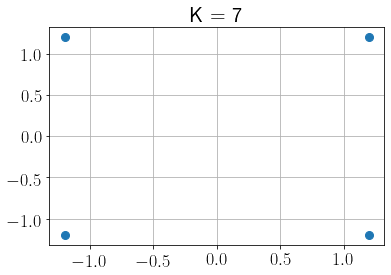

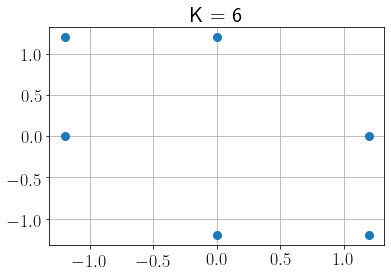

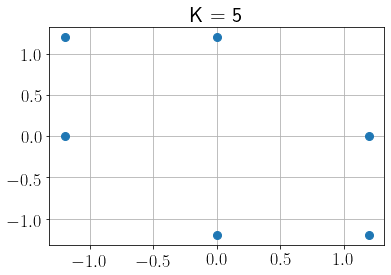

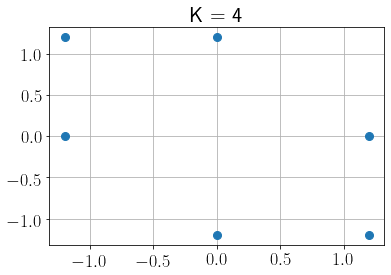

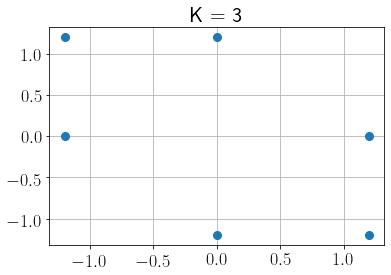

In [134]:
for k in [N+1, N, N-1, N-2, N-3]:
    
    I = lpch.cond_I(k)
    x0 = np.array([0., 0.])
    
    G = np.column_stack([I.A, -I.b])
    hs = HalfspaceIntersection(G, x0)
    x, y = zip(*hs.intersections)
    plt.plot(x, y, 'o', markersize=8)
    plt.title(f"K = {k}")
    plt.grid()
    plt.show()


In [135]:
I = lpch.cond_I(2)

In [136]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})

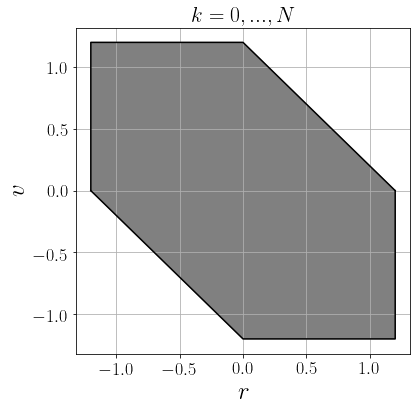

In [137]:
I = lpch.cond_I(6)
G = np.column_stack([I.A, -I.b])
hs = HalfspaceIntersection(G, np.array([0., 0.]))

plt.figure(figsize=(6, 6))

l = list(zip(*hs.intersections))
df_coord = pd.DataFrame({'x': l[0], 'y': l[1]})
#df_coord = df_coord.sort_values(by=['x', 'y'], ascending=[False, True])
df_coord = df_coord.sort_values(by=['x', 'y'], ascending=True)

plt.fill(df_coord[df_coord['y'] >= 0]['x'], df_coord[df_coord['y'] >= 0]['y'], color='grey')
plt.plot(df_coord[df_coord['y'] >= 0]['x'], df_coord[df_coord['y'] >= 0]['y'], color='black')

plt.fill(df_coord[df_coord['y'] <= 0]['x'], df_coord[df_coord['y'] <= 0]['y'], color='grey')
plt.plot(df_coord[df_coord['y'] <= 0]['x'], df_coord[df_coord['y'] <= 0]['y'], color='black')

plt.xlabel(r'$r$', fontsize=25)
plt.ylabel(r'$v$', fontsize=25)
plt.xticks(np.arange(-1, 1.5, 0.5))
plt.yticks(np.arange(-1, 1.5, 0.5))
plt.title('$k = 0,...,N$')
plt.grid()


### Моделирование из одной точки

In [8]:
from scipy.linalg import inv

In [9]:
def modelling(model, control, x0, random_seed=0):
    x_list, u_list = [x0], []

    np.random.seed(random_seed)
    ksi_list = np.random.uniform(
        low=model.m_ksi-model.eps, 
        high=model.m_ksi + model.eps, 
        size=model.N + 1
    )

    for k in np.arange(model.N + 1):
        u_k = control.gamma(k, x_list[-1])
        x = model.f(x_list[-1], u_k, ksi_list[k])        
        
        x_list.append(x)
        u_list.append(u_k)

    return np.array(x_list), np.array(u_list), ksi_list

def plot_modelling(model, x_list, u_list, ksi_list):
    for i in np.arange(model.n):
        plt.figure(figsize=(15, 4))
        plt.plot(x_list[:, i], "o-")
        plt.title(f"Динамика состояния системы по: X_{i + 1}")

        plt.hlines(model.fi / model.vec_lambda[i], 0, len(x_list[:, i]), linestyle="-")
        plt.hlines(-(model.fi / model.vec_lambda[i]), 0, len(x_list[:, i]), linestyle="-")
        plt.grid()

    plt.figure(figsize=(15, 4))
    plt.plot(u_list, "o-")
    plt.title(f"Управление: U")
    plt.grid()

    plt.figure(figsize=(15, 4))
    plt.plot(ksi_list, "o-")
    plt.title(f"Возмущение: Ksi")
    plt.grid()


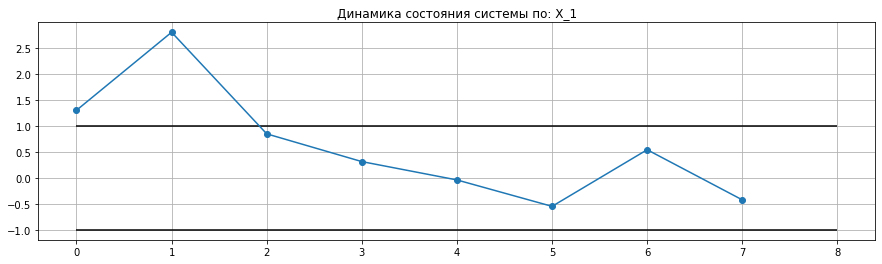

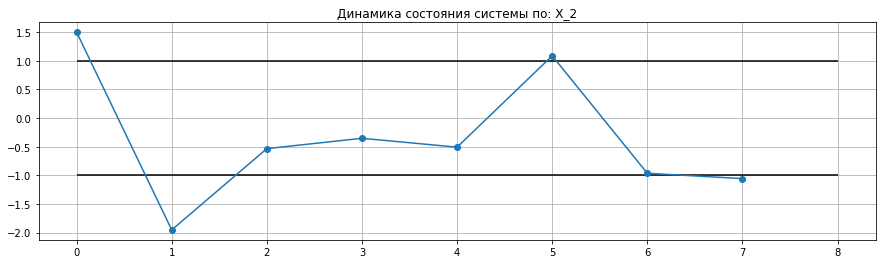

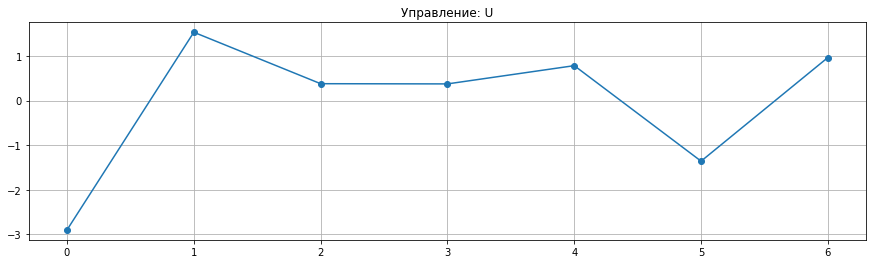

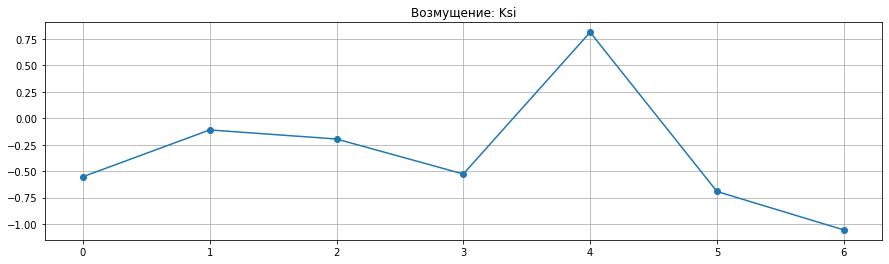

In [10]:
x_list, u_list, ksi_list = modelling(model, lpch, x0=np.array([1.3, 1.5]).reshape(-1, 1), random_seed=33)
plot_modelling(model, x_list, u_list, ksi_list)

In [138]:
def modelling_n(model, control, x_min, x_max, n_sample):
    
    x_res, u_res, ksi_res = [], [], []
    
    x1 = np.linspace(x_min, x_max, int(np.sqrt(n_sample)))
    x2 = np.linspace(x_min, x_max, int(np.sqrt(n_sample)))
    xv, yv = np.meshgrid(x1, x2)
    x0_list = np.array(list(zip(xv.ravel(), yv.ravel())))
    
    for random_seed, x0 in enumerate(x0_list):
        x0 = x0.reshape(-1, 1)
        x_list, u_list = [x0], []
        np.random.seed(random_seed)
        ksi_list = np.random.uniform(
            low=model.m_ksi-model.eps, 
            high=model.m_ksi + model.eps, 
            size=model.N + 1
        )

        for k in np.arange(model.N + 1):            
            u_k = control.gamma(k, x_list[-1])
            x = model.f(x_list[-1], u_k, ksi_list[k])
            
            x_list.append(x)
            u_list.append(u_k)
        
        x_res.append(x_list)
        u_res.append(u_list)
        ksi_res.append(ksi_list)
        
    return np.array(x_res), np.array(u_res), ksi_res

def plot_modelling_n(model, x_res, u_res, ksi_res):
    
    fig, ax = plt.subplots(model.n + 2, 1, figsize=(15, 5*(model.n+2)))
    
    for x_list, u_list, ksi_list in zip(x_res, u_res, ksi_res):
        for i in np.arange(model.n):
            ax[i].plot(x_list[:, i], "-", color='grey')
        
        ax[model.n].plot(u_list, "-", color='grey')
        ax[model.n+1].plot(ksi_list, "-", color='grey')
            
        
    for i in np.arange(model.n):
        ax[i].set_title(f"Динамика состояния системы по: X_{i + 1}")
        ax[i].hlines(model.fi / model.vec_lambda[i], 0, model.N+1, linestyle="-")
        ax[i].hlines(-(model.fi / model.vec_lambda[i]), 0, model.N+1, linestyle="-")
        ax[i].grid()

    ax[model.n].set_title(f"Управление: U")
    ax[model.n].grid()

    ax[model.n+1].set_title(f"Возмущение: Ksi")
    ax[model.n+1].grid()


In [139]:
x_res, u_res, ksi_res = modelling_n(model, lpch, x_min=-2., x_max=2., n_sample=100)
plot_modelling_n(model, x_res, u_res, ksi_res)

RuntimeError: latex was not able to process the following string:
b'\\u0414\\u0438\\u043d\\u0430\\u043c\\u0438\\u043a\\u0430 \\u0441\\u043e\\u0441\\u0442\\u043e\\u044f\\u043d\\u0438\\u044f \\u0441\\u0438\\u0441\\u0442\\u0435\\u043c\\u044b \\u043f\\u043e: X_1'

Here is the full report generated by latex:
This is pdfTeX, Version 3.14159265-2.6-1.40.20 (TeX Live 2019) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(/Users/an.tarasov/.matplotlib/tex.cache/f392fe57691e1edc6bf12538cbfc14bf.tex
LaTeX2e <2018-12-01>
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/article.cls
Document Class: article 2018/09/03 v1.4i Standard LaTeX document class
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2019/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2019/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/textcomp.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1enc.def
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1enc.dfu)))
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2019/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2019/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/oberdiek/ifpdf.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/oberdiek/ifvtex.sty)
(/usr/local/texlive/2019/texmf-dist/tex/generic/ifxetex/ifxetex.sty)

Package geometry Warning: Over-specification in `h'-direction.
    `width' (5058.9pt) is ignored.


Package geometry Warning: Over-specification in `v'-direction.
    `height' (5058.9pt) is ignored.

) (./f392fe57691e1edc6bf12538cbfc14bf.aux)
(/usr/local/texlive/2019/texmf-dist/tex/latex/base/ts1cmr.fd)
*geometry* driver: auto-detecting
*geometry* detected driver: dvips

! Package inputenc Error: Unicode character Д (U+0414)
(inputenc)                not set up for use with LaTeX.

See the inputenc package documentation for explanation.
Type  H <return>  for immediate help.
 ...                                              
                                                  
l.14 \fontsize{21.600000}{27.000000}{\sffamily Д
                                                 инамика состоя...
No pages of output.
Transcript written on f392fe57691e1edc6bf12538cbfc14bf.log.




<Figure size 1080x1440 with 4 Axes>

In [149]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

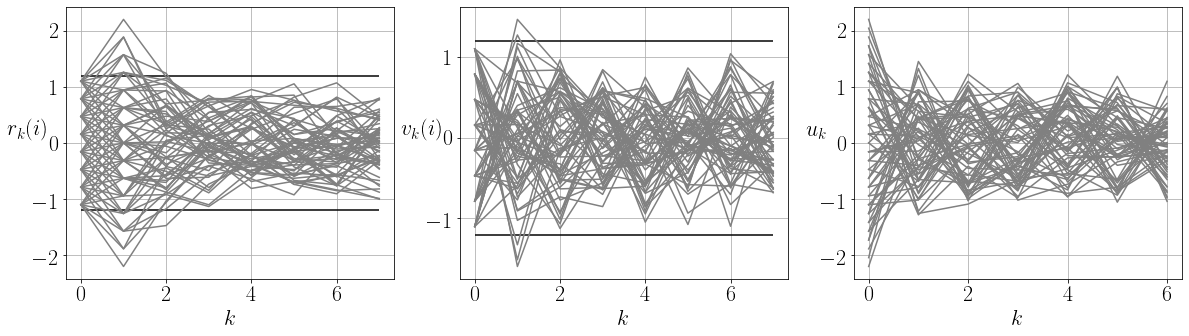

In [158]:
x_res, u_res, ksi_res = [], [], []

x_min = -1.1
x_max = 1.1
n_sample = 8**2

x1 = np.linspace(x_min, x_max, int(np.sqrt(n_sample)))
x2 = np.linspace(x_min, x_max, int(np.sqrt(n_sample)))
xv, yv = np.meshgrid(x1, x2)
x0_list = np.array(list(zip(xv.ravel(), yv.ravel())))

for random_seed, x0 in enumerate(x0_list):
    x0 = x0.reshape(-1, 1)
    x_list, u_list = [x0], []
    np.random.seed(random_seed)
    ksi_list = np.random.uniform(
        low=model.m_ksi-model.eps, 
        high=model.m_ksi + model.eps, 
        size=model.N + 1
    )

    for k in np.arange(model.N + 1):            
        u_k = lpch.gamma(k, x_list[-1])
        x = model.f(x_list[-1], u_k, ksi_list[k])

        x_list.append(x)
        u_list.append(u_k)

    x_res.append(x_list)
    u_res.append(u_list)

x_res = np.array(x_res)
u_res = np.array(u_res)

    
fig, ax = plt.subplots(1, model.n + 1, figsize=(5*(model.n+2), 5))
for x_list, u_list in zip(x_res, u_res):
    ax[0].plot(x_list[:, 0], "-", color='grey')
    ax[0].set_xlabel('$k$')
    ax[0].set_ylabel('$r_k(i)$', rotation=0)
    
    ax[1].plot(x_list[:, 1], "-", color='grey')
    ax[1].set_xlabel('$k$')
    ax[1].set_ylabel('$v_k(i)$', rotation=0)

    ax[model.n].plot(u_list, "-", color='grey')
    ax[model.n].set_xlabel('$k$')
    ax[model.n].set_ylabel('$u_k$', rotation=0)


for i in np.arange(model.n):
    #ax[i].set_title(f"Динамика состояния системы по: X_{i + 1}")
    ax[i].hlines(model.fi / model.vec_lambda[i], 0, model.N+1, linestyle="-")
    ax[i].hlines(-(model.fi / model.vec_lambda[i]), 0, model.N+1, linestyle="-")
    ax[i].grid()

#ax[model.n].set_title(f"Управление: U")
ax[model.n].grid()

## LQG

In [13]:
Q = np.eye(model.n)
R = 0
lqg = LQG(model, Q, R)

### Моделирование из одной точки

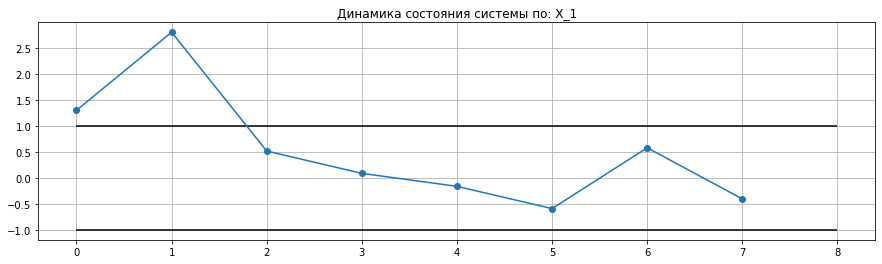

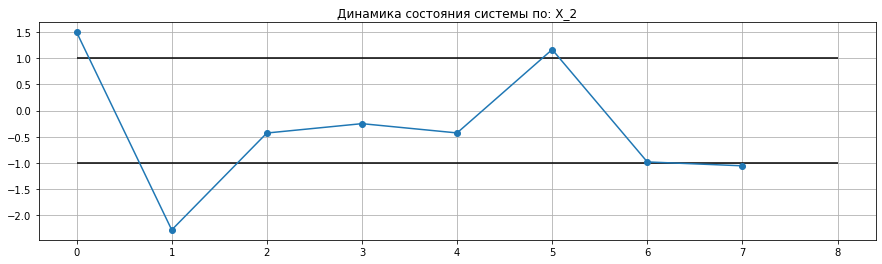

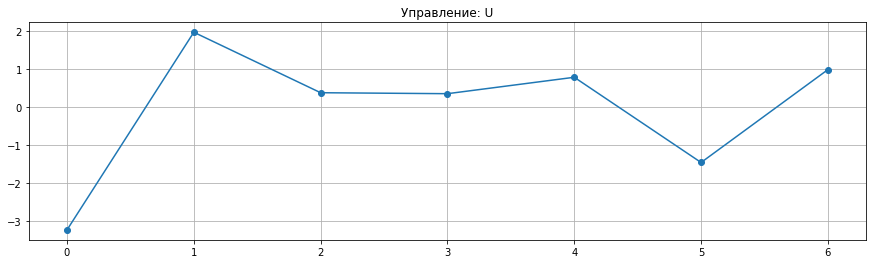

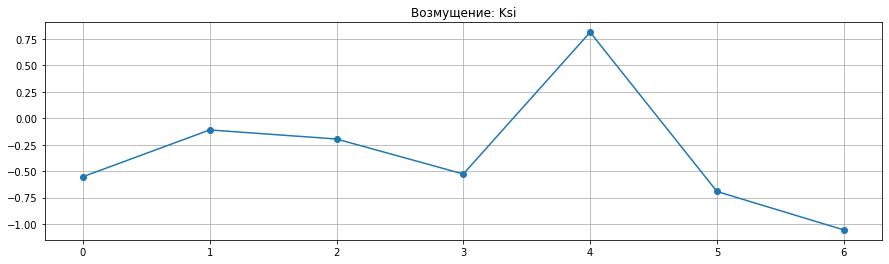

In [14]:
x_list, u_list, ksi_list = modelling(model, lqg, x0=np.array([1.3, 1.5]).reshape(-1, 1), random_seed=33)
plot_modelling(model, x_list, u_list, ksi_list)

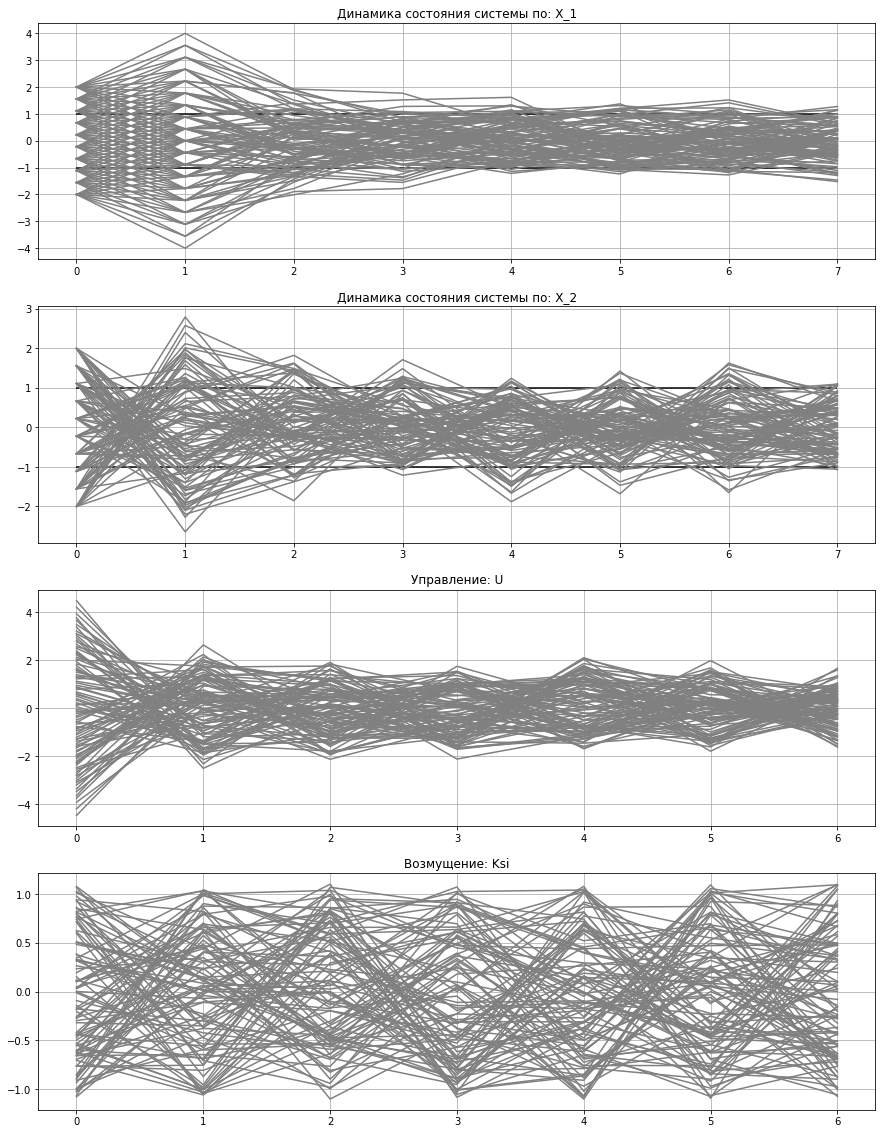

In [15]:
x_res, u_res, ksi_res = modelling_n(model, lqg, x_min=-2., x_max=2., n_sample=100)
plot_modelling_n(model, x_res, u_res, ksi_res)

## Сравнение для одной точки

In [16]:
def plot_modelling_compare(
    model, exp1, exp2
):
    for i in np.arange(model.n):
        plt.figure(figsize=(15, 4))
        plt.plot(exp1['x'][:, i], "o-", label=exp1['name'])
        plt.plot(exp2['x'][:, i], "o-", label=exp2['name'])
        plt.title(f"Динамика состояния системы по: X_{i + 1}")

        plt.hlines(model.fi / model.vec_lambda[i], 0, model.N+1, linestyle="-")
        plt.hlines(-(model.fi / model.vec_lambda[i]), 0,  model.N+1, linestyle="-")
        plt.grid()
        plt.legend()

    plt.figure(figsize=(15, 4))
    plt.plot(exp1['u'], "o-", label=exp1['name'])
    plt.plot(exp2['u'], "o-", label=exp2['name'])
    plt.title(f"Управление: U")
    plt.grid()
    plt.legend()

    plt.figure(figsize=(15, 4))
    plt.plot(exp1['ksi'], "o-", label=exp1['name'])
    plt.plot(exp2['ksi'], "o-", label=exp2['name'])
    plt.title(f"Возмущение: Ksi")
    plt.grid()
    plt.legend()


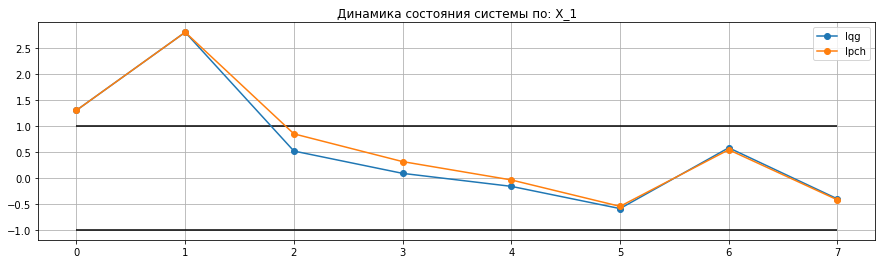

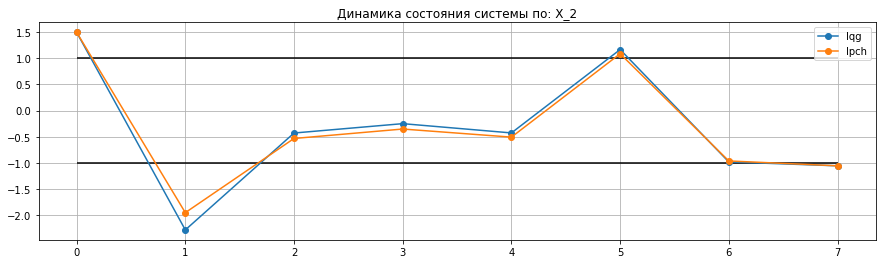

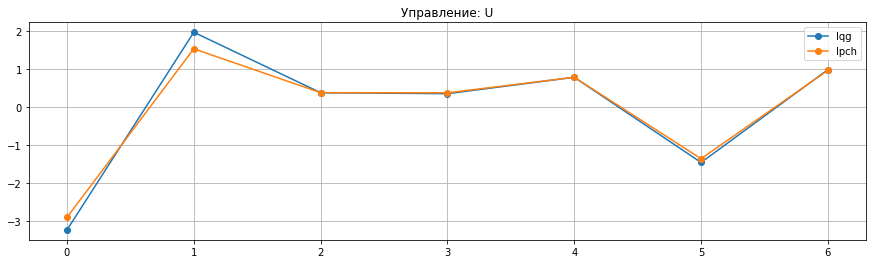

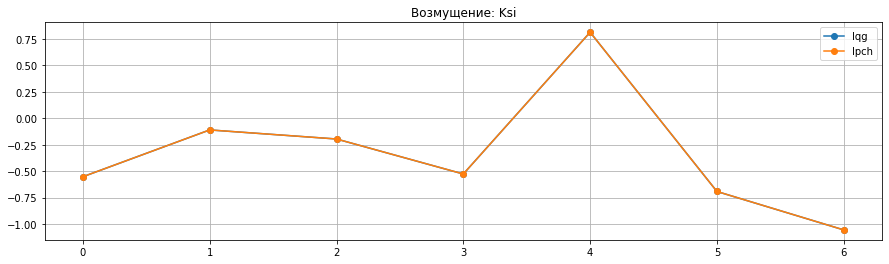

In [17]:
x_lqg, u_lqg, ksi_lqg = modelling(model, lqg, x0=np.array([1.3, 1.5]).reshape(-1, 1), random_seed=33)
x_lpch, u_lpch, ksi_lpch = modelling(model, lpch, x0=np.array([1.3, 1.5]).reshape(-1, 1), random_seed=33)

exp_lqg = {'x': x_lqg, 'u': u_lqg, 'ksi': ksi_lqg, 'name': 'lqg'}
exp_lpch = {'x': x_lpch, 'u': u_lpch, 'ksi': ksi_lpch, 'name': 'lpch'}

plot_modelling_compare(model, exp_lqg, exp_lpch)


## Сравнение критериев

In [18]:
def modelling_x0_n(model, control, x0, n_sample):
    x_res, u_res, ksi_res = [], [], []
    for random_seed in enumerate(range(n_sample)):
        x_list, u_list = [x0], []
        np.random.seed(random_seed)
        ksi_list = np.random.uniform(
            low=model.m_ksi-model.eps, 
            high=model.m_ksi + model.eps, 
            size=model.N + 1
        )

        for k in np.arange(model.N + 1):            
            u_k = control.gamma(k, x_list[-1])
            x = model.f(x_list[-1], u_k, ksi_list[k])
            
            x_list.append(x)
            u_list.append(u_k)
        
        x_res.append(x_list)
        u_res.append(u_list)
        ksi_res.append(ksi_list)
        
    return np.array(x_res), np.array(u_res), ksi_res

Crit probability: 0.148
Crit expectation: 0.41487210434278265


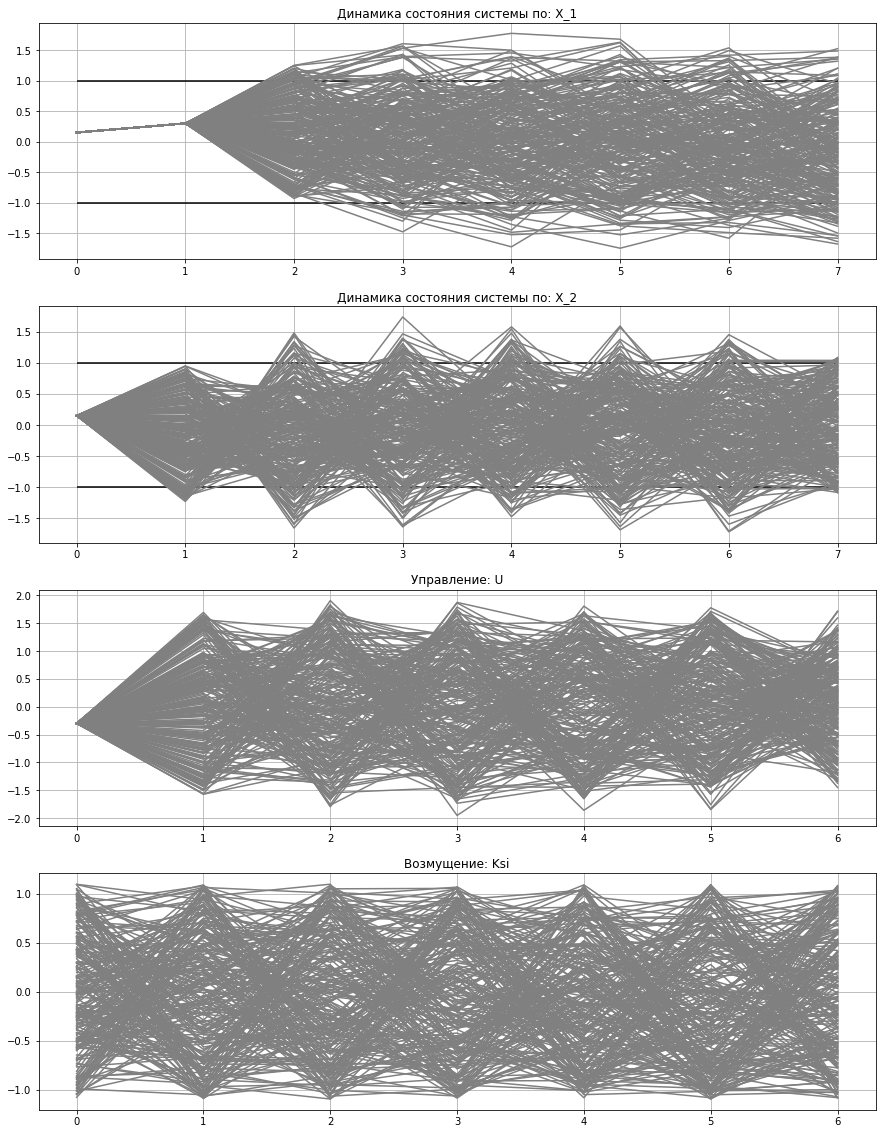

In [19]:
x_res, u_res, ksi_res = modelling_x0_n(model, lpch, x0=np.array([0.15, 0.15]).reshape(-1, 1), n_sample=250)
print(f"Crit probability: {model.criterion_retention(x_res)}")
print(f"Crit expectation: {model.criterion_math_expectation(x_res)}")


plot_modelling_n(model, x_res, u_res, ksi_res)

Crit probability: 0.16
Crit expectation: 0.41282880791660487


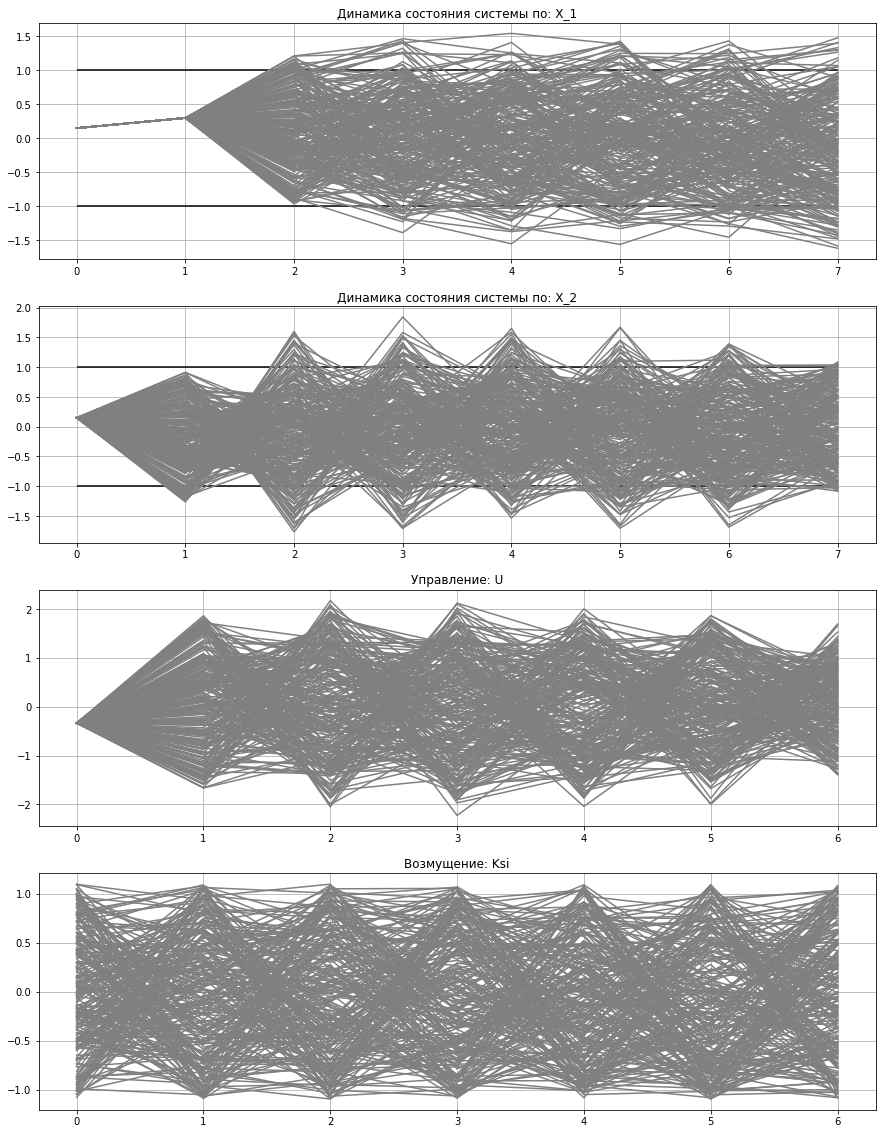

In [20]:
x_res, u_res, ksi_res = modelling_x0_n(model, lqg, x0=np.array([0.15, 0.15]).reshape(-1, 1), n_sample=250)
plot_modelling_n(model, x_res, u_res, ksi_res)
print(f"Crit probability: {model.criterion_retention(x_res)}")
print(f"Crit expectation: {model.criterion_math_expectation(x_res)}")

In [42]:
mtx_A = np.array([[1, 1],
                  [0, 1]])
N = 6
n = 2

model = Model(
    mtx_A, b=1., c=1.,
    n=n, N=N,
    vec_lambda=np.array([1, 1]),
    fi=1.,
    m_ksi=0.0,
    eps=0.7,
)

In [43]:
from tqdm.notebook import tqdm

In [44]:
n_sample = (25)**2
x_min = -1.1
x_max = 1.1


x1 = np.linspace(x_min, x_max, int(np.sqrt(n_sample)))
x2 = np.linspace(x_min, x_max, int(np.sqrt(n_sample)))

X, Y = np.meshgrid(x1,x2)
Z_lpch_retention = np.zeros((X.shape[0], X.shape[0]))
Z_lpch_expectation = np.zeros((X.shape[0], X.shape[0]))
Z_lqg_retention = np.zeros((X.shape[0], X.shape[0]))
Z_lqg_expectation = np.zeros((X.shape[0], X.shape[0]))

for i in tqdm(range(X.shape[0])):
    for j in range(X.shape[0]):
        x_res, u_res, ksi_res = modelling_x0_n(model, lpch, x0=np.array([X[i, j], Y[i, j]]).reshape(-1, 1), n_sample=50)
        Z_lpch_retention[i, j] = model.criterion_retention(x_res)
        Z_lpch_expectation[i, j] = model.criterion_math_expectation(x_res)

        x_res, u_res, ksi_res = modelling_x0_n(model, lqg, x0=np.array([X[i, j], Y[i, j]]).reshape(-1, 1), n_sample=50)
        Z_lqg_retention[i, j] = model.criterion_retention(x_res)
        Z_lqg_expectation[i, j] = model.criterion_math_expectation(x_res)

In [45]:
# fig, ax = plt.subplots(subplot_kw={'projection': '3d'})
# ax.plot_surface(X, Y, Z_lpch_expectation)

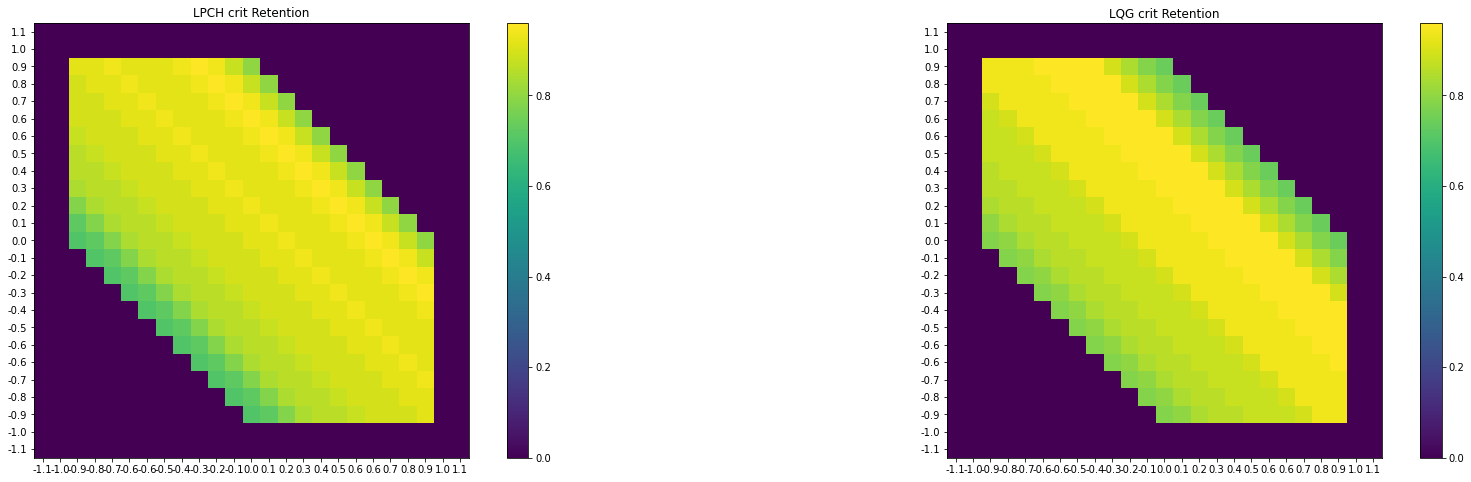

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(30, 8))
for i, (Z, name) in enumerate(zip([Z_lpch_retention, Z_lqg_retention], ['LPCH crit Retention', 'LQG crit Retention'])):
    
    ax[i].set_title(name)
    im = ax[i].imshow(Z, origin='lower', interpolation="none")

    ax[i].set_xticks(np.arange(X.shape[1])) 
    ax[i].set_xticklabels(np.round(X[0],1))
    
    ax[i].set_yticks(np.arange(Y.shape[0])) 
    ax[i].set_yticklabels(np.round(Y[:, 0],1))
    
    
    #ax[i].set_yticks(np.arange(Y.shape[0]), np.round(Y[:,0],3))
    plt.colorbar(im, ax=ax[i])

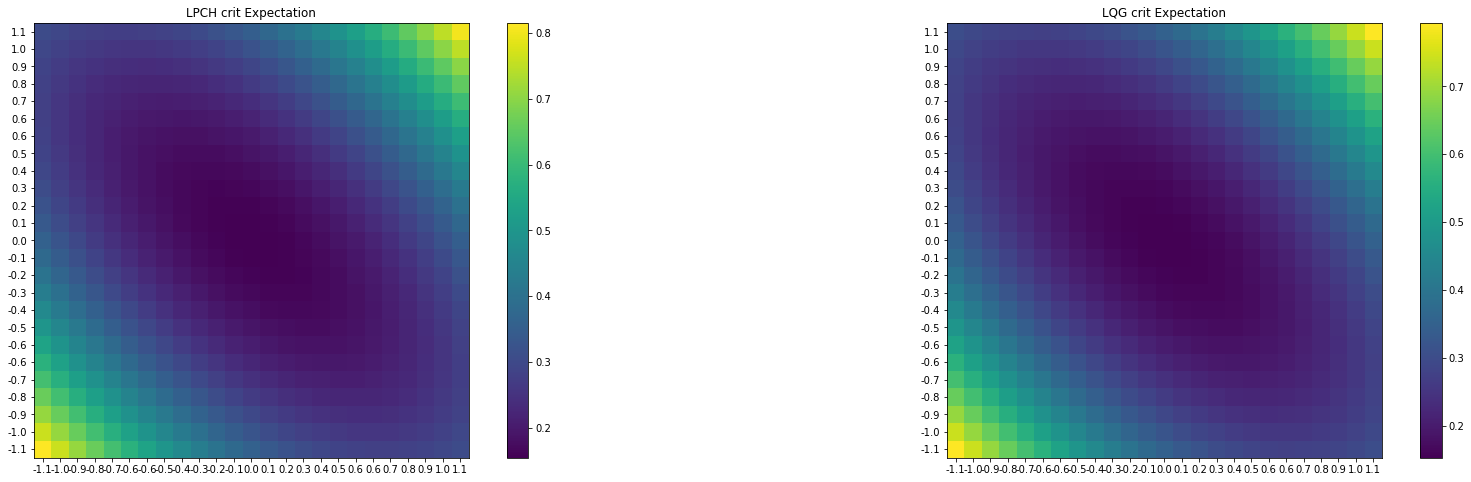

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(30, 8))
for i, (Z, name) in enumerate(zip([Z_lpch_expectation, Z_lqg_expectation], ['LPCH crit Expectation', 'LQG crit Expectation'])):
    
    ax[i].set_title(name)
    im = ax[i].imshow(Z, origin='lower', interpolation="none")

    ax[i].set_xticks(np.arange(X.shape[1])) 
    ax[i].set_xticklabels(np.round(X[0],1))
    
    ax[i].set_yticks(np.arange(Y.shape[0])) 
    ax[i].set_yticklabels(np.round(Y[:, 0],1))
    
    
    #ax[i].set_yticks(np.arange(Y.shape[0]), np.round(Y[:,0],3))
    plt.colorbar(im, ax=ax[i])

## В зависимости от fi критерий удержания

In [242]:
mtx_A = np.array([[1, 1],
                  [0, 1]])
N = 6
n = 2

m_ksi = 0.0
eps = 0.7

x0 = np.array([0.5, 0.5]).reshape(-1, 1)

ret_lpch_list = []
ret_lqg_list = []
fi_list = np.arange(0.95, 1.35, 0.005)

for fi in tqdm(fi_list):
    model = Model(
        mtx_A, b=1., c=1.,
        n=n, N=N,
        vec_lambda=np.array([1, 1]),
        fi=fi,
        m_ksi=m_ksi,
        eps=eps,
    )
    
    x_res, u_res, ksi_res = modelling_x0_n(model, lpch, x0=x0, n_sample=1000)
    ret_lpch = model.criterion_retention(x_res)
    
    x_res, u_res, ksi_res = modelling_x0_n(model, lqg, x0=x0, n_sample=1000)
    ret_lqg = model.criterion_retention(x_res)
    
    #math_exp = model.criterion_math_expectation(x_res)
    
    ret_lpch_list.append(ret_lpch)
    ret_lqg_list.append(ret_lqg)

In [240]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 20})

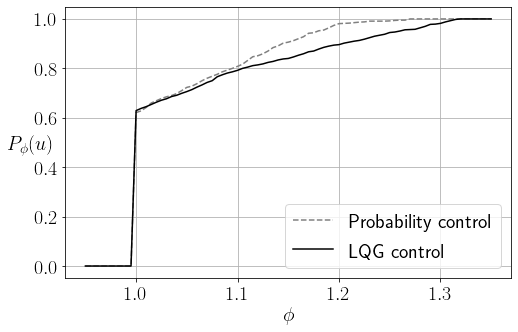

In [243]:
plt.figure(figsize=(8,5))
plt.plot(fi_list, ret_lpch_list, '--',color='grey', label='Probability control')
plt.plot(fi_list, ret_lqg_list, color='black', label='LQG control')
#plt.ylabel('$P_{\varphi}(u)$')
#plt.xlabel('$\varphi$')

plt.ylabel('$P_{\phi}(u)$', rotation=0,  y=0.45)
plt.xlabel('$\phi$')
plt.legend()
plt.grid()

## В зависимости от начальной точки крит. мат. ожидания

In [244]:
mtx_A = np.array([[1, 1],
                  [0, 1]])
N = 6
n = 2

m_ksi = 0.0
eps = 0.7


model = Model(
    mtx_A, b=1., c=1.,
    n=n, N=N,
    vec_lambda=np.array([1, 1]),
    fi=1.2,
    m_ksi=m_ksi,
    eps=eps,
)


exp_lpch_list = []
exp_lqg_list = []

x2 = 0.5
x1_list = np.arange(-2, 2, 0.05)

for x1 in tqdm(x1_list):
    
    x0 = np.array([x1, x2]).reshape(-1, 1)
    x_res, u_res, ksi_res = modelling_x0_n(model, lpch, x0=x0, n_sample=500)
    exp_lpch = model.criterion_math_expectation(x_res)
    
    x_res, u_res, ksi_res = modelling_x0_n(model, lqg, x0=x0, n_sample=500)
    exp_lqg = model.criterion_math_expectation(x_res)
    
    #math_exp = model.criterion_math_expectation(x_res)
    
    exp_lpch_list.append(exp_lpch)
    exp_lqg_list.append(exp_lqg)

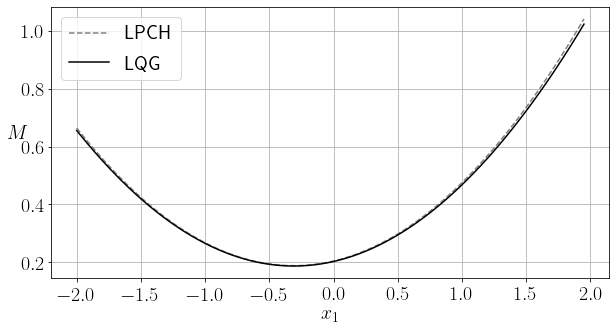

In [248]:
plt.figure(figsize=(10,5))
plt.plot(x1_list, exp_lpch_list, '--',color='grey', label='LPCH')
plt.plot(x1_list, exp_lqg_list, color='black', label='LQG')
plt.ylabel('$M$', rotation=0)
plt.xlabel('$x_1$')

plt.legend()
plt.grid()

In [265]:
# fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# ax[0].plot(fi_list, ret_lpch_list, '--',color='grey', label='Probability control')
# ax[0].plot(fi_list, ret_lqg_list, color='black', label='LQG control')
# ax[0].set_ylabel('$P_{\phi}(u)$', rotation=0,  y=0.45,x=0.1)
# ax[0].set_xlabel('$\phi$')
# ax[0].legend()
# ax[0].grid()

# ax[1].plot(x1_list, exp_lpch_list, '--',color='grey', label='Probability control')
# ax[1].plot(x1_list, exp_lqg_list, color='black', label='LQG control')

# ax[1].set_yticks(np.arange(0.0, 1.2, 0.2))
# ax[1].set_ylabel('$J(u(\cdot))$', rotation=0, y=0.43)
# ax[1].set_xlabel('$x_1$')


# ax[1].legend(loc='lower right')
# ax[1].grid()

In [ ]:
# plt.figure(figsize=(10, 10))
# #plt.title('distance to point (1, 2)')
# plt.imshow(Z_lpch_retention, origin='lower', interpolation="none")

# plt.xticks(np.arange(X.shape[1]), np.round(X[0],3))  # need to set the ticks manually
# plt.yticks(np.arange(Y.shape[0]), np.round(Y[:,0],3))
# plt.colorbar()

In [ ]:
# plt.pcolormesh(X, Y, Z_lpch_retention)
# plt.show()

# plt.pcolormesh(X, Y, Z_lpch_expectation,)
# plt.show()

# plt.pcolormesh(X, Y, Z_lqg_retention)
# plt.show()

# plt.pcolormesh(X, Y, Z_lqg_expectation)
# plt.show()


In [ ]:
# def modelling_crit(model, ctr1, ctr2, x0, n_sample):
    
#     x_ctr1, u_ctr1, ksi_ctr1 = [], [], []
#     x_ctr2, u_ctr2, ksi_ctr2 = [], [], []
    
#     for random_seed in enumerate(n_sample):
        
#         x_list_ctr1, u_list_ctr1 = [x0], []
#         x_list_ctr2, u_list_ctr2 = [x0], []
        
#         np.random.seed(random_seed)
#         ksi_list = np.random.uniform(
#             low=model.m_ksi-model.eps, 
#             high=model.m_ksi + model.eps, 
#             size=model.N + 1
#         )

#         for k in np.arange(model.N + 1):            
#             u_k = control.gamma(k, x_list[-1])
#             x = model.f(x_list[-1], u_k, ksi_list[k])
            
#             x_list.append(x)
#             u_list.append(u_k)
        
#         x_res.append(x_list)
#         u_res.append(u_list)
#         ksi_res.append(ksi_list)
        
        
        
        
#    return np.array(x_res), np.array(u_res), ksi_res

# def plot_modelling_n(model, x_res, u_res, ksi_res):
    
#     fig, ax = plt.subplots(model.n + 2, 1, figsize=(15, 5*(model.n+2)))
    
#     for x_list, u_list, ksi_list in zip(x_res, u_res, ksi_res):
#         for i in np.arange(model.n):
#             ax[i].plot(x_list[:, i], "-", color='grey')
        
#         ax[model.n].plot(u_list, "-", color='grey')
#         ax[model.n+1].plot(ksi_list, "-", color='grey')
            
        
#     for i in np.arange(model.n):
#         ax[i].set_title(f"Динамика состояния системы по: X_{i + 1}")
#         ax[i].hlines(model.fi / model.vec_lambda[i], 0, model.N+1, linestyle="-")
#         ax[i].hlines(-(model.fi / model.vec_lambda[i]), 0, model.N+1, linestyle="-")
#         ax[i].grid()

#     ax[model.n].set_title(f"Управление: U")
#     ax[model.n].grid()

#     ax[model.n+1].set_title(f"Возмущение: Ksi")
#     ax[model.n+1].grid()


In [ ]:
# res = []
# xx1 = []
# xx2 = []

# for x1 in np.arange(-2,2,0.25):
#     for x2 in np.arange(-2,2,0.25):
#         x=np.array([x1, x2])
    
#         u = sys.gamma(k=0, x=x)
#         res.append(u)
#         xx1.append(x1)
#         xx2.append(x2)

In [ ]:
# print('Lambda wave N+1')
# print(sys.mtx_Lambda_wave(N+1))
# print('Lambda N+1')
# print(sys.mtx_Lambda(N + 1))

# print('Lambda wave N')
# print(sys.mtx_Lambda_wave(N))
# print('Lambda N')
# print(sys.mtx_Lambda(N))

# print('Lambda wave N-1')
# print(sys.mtx_Lambda_wave(N-1))
# print('Lambda N-1')
# print(sys.mtx_Lambda(N - 1))

# print('Lambda wave N-2')
# print(sys.mtx_Lambda_wave(N - 2))

# print('Lambda N-2')
# print(sys.mtx_Lambda(N - 2))

# #sys.gamma(N - 1, np.array([0.25, 0.25]))
# u_k = sys.gamma(1, np.array([0.25, 0.25]))
# #u_k = sys.gamma(2, np.array([0.25, 0.25]))
# #u_k = sys.gamma(3, np.array([0.25, 0.25]))
